In [6]:
import os
import pandas as pd
import numpy as np
import nltk
import praw
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud, STOPWORDS 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import datetime as dt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
%matplotlib inline

In [7]:
flairs=['Food','Politics','Sports','Business/Finance','Scheduled','Coronavirus','Science/Technology','Photography','AMA','Policy/Economy',
'Non-Political','AskIndia','CAA-NRC-NPR','[R]eddiquette']     

In [8]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [9]:
df=pd.read_csv("reddit-india-data.csv")
df.columns

Index(['flair', 'title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'author', 'comments'],
      dtype='object')

In [10]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", "nan","https", "www", "com" ])

##### The snippet below takes any text as input and replaces shortcuts, so that while removing special characters everything 

In [11]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

1. The snippet below removes all special characters
2. removes all html tags
3. removes links

In [12]:
df["Text"] = df["title"].map(str) + df["body"].map(str) + df["comments"].map(str) 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(df['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 2791/2791 [00:07<00:00, 377.29it/s]


## Bag of Words Vectorizations
1. Splits data into train and test
2. The snippet below vectorizes the text data using BoW featurization technique


In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
y=df['flair'][:]
# y = preprocessing.label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
X=preprocessed_reviews[:]

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)
bow = CountVectorizer()
X_train_bow=bow.fit_transform(X_train)
X_test_bow=bow.transform(X_test)
print(X_train_bow.shape, y_train.shape)

(1953, 47629) (1953,)


### Logistic Regression

In [23]:
from sklearn.linear_model import SGDClassifier
lg=SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)

lg.fit(X_train_bow, y_train)
y_pred = lg.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=flairs))

accuracy 0.5727923627684964
                    precision    recall  f1-score   support

              Food       0.67      0.71      0.69        75
          Politics       0.31      0.34      0.33        47
            Sports       0.57      0.58      0.57        73
  Business/Finance       0.79      0.90      0.84        21
         Scheduled       0.81      0.87      0.84        71
       Coronavirus       0.66      0.72      0.69        71
Science/Technology       0.69      0.55      0.62        65
       Photography       0.87      0.71      0.78        65
               AMA       0.66      0.34      0.45        68
    Policy/Economy       0.63      0.29      0.40        65
     Non-Political       0.55      0.49      0.52        74
          AskIndia       0.60      0.55      0.57        62
       CAA-NRC-NPR       0.72      0.53      0.61        74
     [R]eddiquette       0.04      0.57      0.07         7

          accuracy                           0.57       838
         m

### Decision Tree

accuracy 0.7637231503579952
classification report                     precision    recall  f1-score   support

              Food       0.94      0.91      0.93        75
          Politics       0.70      0.70      0.70        47
            Sports       0.60      0.62      0.61        73
  Business/Finance       0.85      0.81      0.83        21
         Scheduled       0.89      0.92      0.90        71
       Coronavirus       0.75      0.83      0.79        71
Science/Technology       0.80      0.86      0.83        65
       Photography       0.82      0.92      0.87        65
               AMA       0.65      0.50      0.57        68
    Policy/Economy       0.57      0.65      0.60        65
     Non-Political       0.85      0.78      0.82        74
          AskIndia       0.88      0.79      0.83        62
       CAA-NRC-NPR       0.66      0.66      0.66        74
     [R]eddiquette       1.00      0.71      0.83         7

          accuracy                           0.7

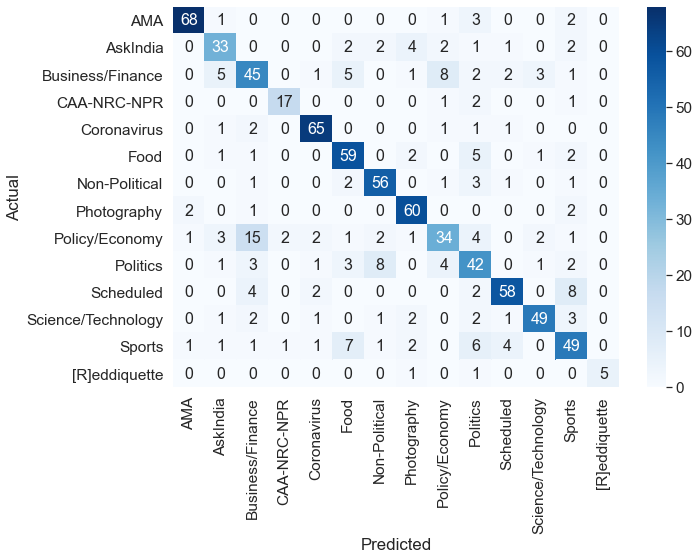

In [15]:
clf=tree.DecisionTreeClassifier()

clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

### Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   57.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.2s finished


accuracy 0.7732696897374701
classification report                     precision    recall  f1-score   support

              Food       0.69      0.89      0.78        75
          Politics       0.81      0.55      0.66        47
            Sports       0.75      0.74      0.74        73
  Business/Finance       0.91      0.95      0.93        21
         Scheduled       0.91      0.90      0.91        71
       Coronavirus       0.76      0.83      0.79        71
Science/Technology       0.80      0.82      0.81        65
       Photography       0.83      0.89      0.86        65
               AMA       0.69      0.71      0.70        68
    Policy/Economy       0.64      0.72      0.68        65
     Non-Political       0.88      0.62      0.73        74
          AskIndia       0.79      0.74      0.77        62
       CAA-NRC-NPR       0.77      0.74      0.76        74
     [R]eddiquette       0.83      0.71      0.77         7

          accuracy                           0.7

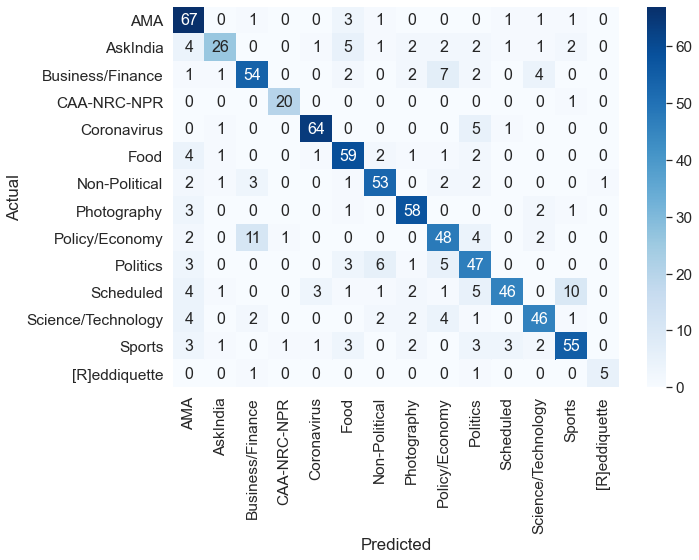

In [17]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators = 1000, random_state = 42,n_jobs=-1,verbose=1)

clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

In [21]:
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

### Building Adaboost with taking SGDClassifier as base estimator

accuracy 0.6157517899761337
classification report                     precision    recall  f1-score   support

              Food       0.94      0.23      0.37        75
          Politics       0.25      0.43      0.31        47
            Sports       0.82      0.44      0.57        73
  Business/Finance       1.00      0.62      0.76        21
         Scheduled       0.95      0.77      0.85        71
       Coronavirus       0.60      0.73      0.66        71
Science/Technology       0.87      0.69      0.77        65
       Photography       0.98      0.77      0.86        65
               AMA       0.73      0.60      0.66        68
    Policy/Economy       0.45      0.75      0.56        65
     Non-Political       0.59      0.61      0.60        74
          AskIndia       0.81      0.47      0.59        62
       CAA-NRC-NPR       0.41      0.88      0.56        74
     [R]eddiquette       1.00      0.43      0.60         7

          accuracy                           0.6

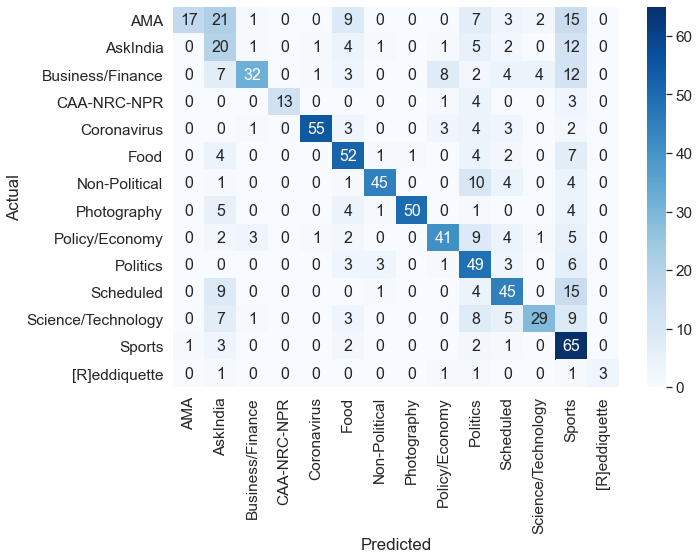

In [24]:
ada=AdaBoostClassifier(base_estimator=lg,n_estimators=1000,random_state=420)
ada.fit(X_train_bow, y_train)
y_pred = ada.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

accuracy 0.8353221957040573
classification report                     precision    recall  f1-score   support

              Food       0.96      0.95      0.95        75
          Politics       0.89      0.72      0.80        47
            Sports       0.80      0.77      0.78        73
  Business/Finance       0.90      0.90      0.90        21
         Scheduled       0.91      0.94      0.92        71
       Coronavirus       0.77      0.87      0.82        71
Science/Technology       0.91      0.89      0.90        65
       Photography       0.94      0.95      0.95        65
               AMA       0.85      0.69      0.76        68
    Policy/Economy       0.55      0.74      0.63        65
     Non-Political       0.87      0.80      0.83        74
          AskIndia       0.87      0.87      0.87        62
       CAA-NRC-NPR       0.80      0.77      0.79        74
     [R]eddiquette       0.86      0.86      0.86         7

          accuracy                           0.8

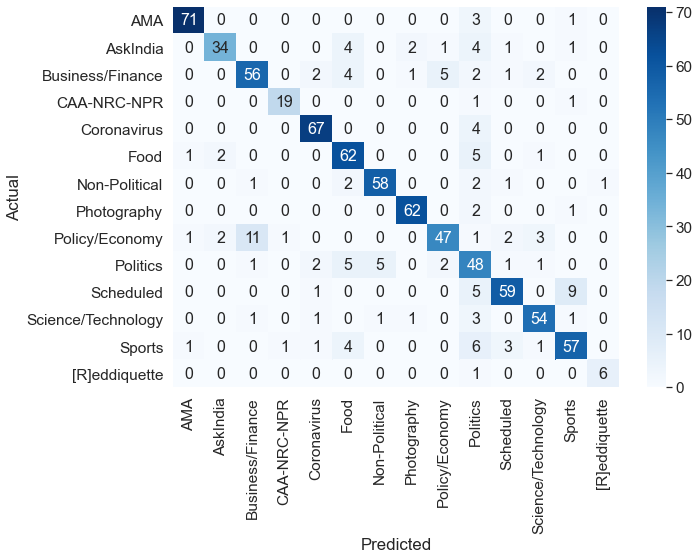

In [35]:
gbc=GradientBoostingClassifier(random_state=420)
gbc.fit(X_train_bow, y_train)
y_pred = gbc.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

accuracy 0.8305489260143198
classification report                     precision    recall  f1-score   support

              Food       0.95      0.95      0.95        75
          Politics       0.92      0.72      0.81        47
            Sports       0.80      0.75      0.77        73
  Business/Finance       0.95      0.90      0.93        21
         Scheduled       0.91      0.94      0.92        71
       Coronavirus       0.75      0.86      0.80        71
Science/Technology       0.86      0.88      0.87        65
       Photography       0.93      0.95      0.94        65
               AMA       0.84      0.71      0.77        68
    Policy/Economy       0.55      0.71      0.62        65
     Non-Political       0.87      0.80      0.83        74
          AskIndia       0.86      0.87      0.86        62
       CAA-NRC-NPR       0.80      0.77      0.79        74
     [R]eddiquette       0.86      0.86      0.86         7

          accuracy                           0.8

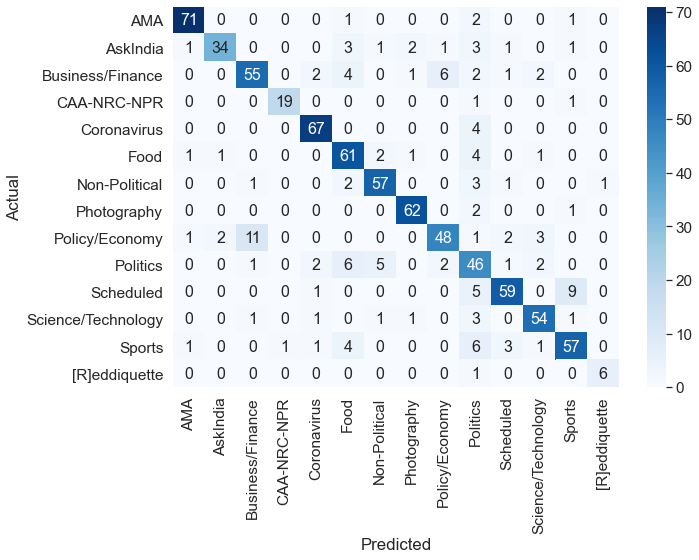

In [36]:
gbc=GradientBoostingClassifier(n_estimators=250,random_state=420)
gbc.fit(X_train_bow, y_train)
y_pred = gbc.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

In [41]:
from catboost import CatBoostClassifier

accuracy 0.8126491646778043
classification report                     precision    recall  f1-score   support

              Food       0.93      0.89      0.91        75
          Politics       0.90      0.77      0.83        47
            Sports       0.78      0.74      0.76        73
  Business/Finance       0.95      0.90      0.93        21
         Scheduled       0.93      0.92      0.92        71
       Coronavirus       0.76      0.83      0.79        71
Science/Technology       0.90      0.92      0.91        65
       Photography       0.98      0.91      0.94        65
               AMA       0.74      0.68      0.71        68
    Policy/Economy       0.48      0.66      0.56        65
     Non-Political       0.87      0.81      0.84        74
          AskIndia       0.77      0.79      0.78        62
       CAA-NRC-NPR       0.81      0.80      0.80        74
     [R]eddiquette       1.00      0.71      0.83         7

          accuracy                           0.8

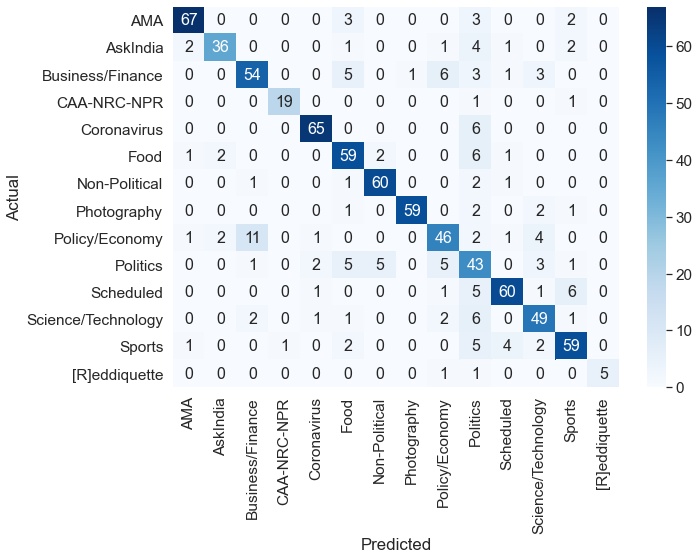

In [45]:
cb=CatBoostClassifier(iterations=150,verbose=False)
cb.fit(X_train_bow, y_train)
y_pred = cb.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

### Creating a stacked model

In [28]:
pip install -e 'git+http://github.com/dustinstansbury/stacked_generalization.git#egg=stacked_generalization'

Obtaining stacked_generalization from git+http://github.com/dustinstansbury/stacked_generalization.git#egg=stacked_generalization
  Updating ./src/stacked-generalization clone
  Running command git fetch -q --tags
  Running command git reset --hard -q fcf0701174e78231738ef6c2e3b9ce1d01bf541a
  Attempting uninstall: stacked-generalization
    Found existing installation: stacked-generalization 0.0.0
    Uninstalling stacked-generalization-0.0.0:
      Successfully uninstalled stacked-generalization-0.0.0
  Running setup.py develop for stacked-generalization
Note: you may need to restart the kernel to use updated packages.


In [48]:
import stacked_generalizer #import StackedGeneralizer
from sklearn.ensemble import ExtraTreesClassifier

ModuleNotFoundError: No module named 'stacked_generalizer'

In [ ]:
VERBOSE = True
N_FOLDS = 5
#Base models
base_models = [RandomForestClassifier(n_estimators=1000, n_jobs=-1, criterion='gini'),
               RandomForestClassifier(n_estimators=1000, n_jobs=-1, criterion='entropy'),
               ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, criterion='gini')]

In [ ]:
# define blending model
blending_model = LogisticRegression()

In [ ]:
# initialize multi-stage model
sg = StackedGeneralizer(base_models, blending_model,n_folds=N_FOLDS, verbose=VERBOSE)

In [ ]:
sg.fit.fit(X_train_bow, y_train)

In [ ]:
y_pred = sg.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

## Using TFIDF Vectorizations

In [30]:
y=df['flair'][:]
# y = preprocessing.label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
X=preprocessed_reviews[:]

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)
tfidf = TfidfVectorizer()
X_train_tfidf=tfidf.fit_transform(X_train)
X_test_tfidf=tfidf.transform(X_test)
print(X_train_tfidf.shape, y_train.shape)

(1953, 47629) (1953,)


In [ ]:
#joblib.dump(tfidf, 'count_vect.pkl')

### Logistic Regression

accuracy 0.7136038186157518
classification report                     precision    recall  f1-score   support

              Food       0.77      0.79      0.78        75
          Politics       0.49      0.47      0.48        47
            Sports       0.55      0.74      0.63        73
  Business/Finance       1.00      0.67      0.80        21
         Scheduled       0.91      0.87      0.89        71
       Coronavirus       0.69      0.83      0.75        71
Science/Technology       0.80      0.66      0.72        65
       Photography       1.00      0.85      0.92        65
               AMA       0.65      0.57      0.61        68
    Policy/Economy       0.54      0.75      0.63        65
     Non-Political       0.76      0.53      0.62        74
          AskIndia       0.67      0.73      0.70        62
       CAA-NRC-NPR       0.81      0.78      0.79        74
     [R]eddiquette       0.00      0.00      0.00         7

          accuracy                           0.7

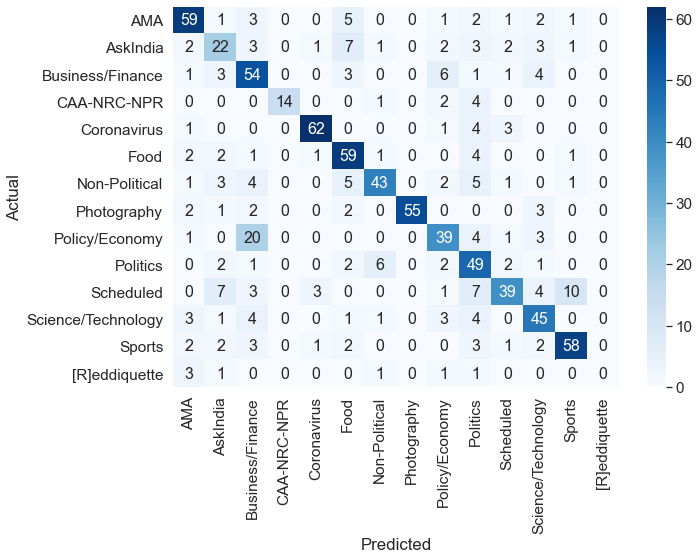

In [31]:
clf=SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)

clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

### Decision Tree

accuracy 0.7637231503579952
classification report                     precision    recall  f1-score   support

              Food       0.97      0.92      0.95        75
          Politics       0.83      0.72      0.77        47
            Sports       0.57      0.64      0.61        73
  Business/Finance       0.90      0.86      0.88        21
         Scheduled       0.85      0.93      0.89        71
       Coronavirus       0.73      0.83      0.78        71
Science/Technology       0.84      0.82      0.83        65
       Photography       0.91      0.92      0.92        65
               AMA       0.61      0.49      0.54        68
    Policy/Economy       0.62      0.62      0.62        65
     Non-Political       0.84      0.77      0.80        74
          AskIndia       0.77      0.77      0.77        62
       CAA-NRC-NPR       0.62      0.69      0.65        74
     [R]eddiquette       1.00      0.71      0.83         7

          accuracy                           0.7

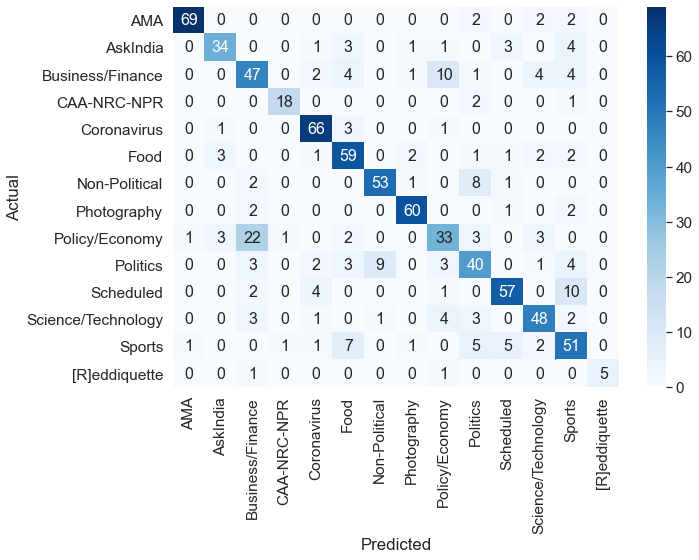

In [32]:
clf=tree.DecisionTreeClassifier()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

### Random forest

accuracy 0.7756563245823389
classification report                     precision    recall  f1-score   support

              Food       0.76      0.89      0.82        75
          Politics       0.70      0.60      0.64        47
            Sports       0.67      0.77      0.71        73
  Business/Finance       0.91      0.95      0.93        21
         Scheduled       0.91      0.90      0.91        71
       Coronavirus       0.76      0.83      0.79        71
Science/Technology       0.78      0.80      0.79        65
       Photography       0.84      0.89      0.87        65
               AMA       0.72      0.63      0.67        68
    Policy/Economy       0.67      0.71      0.69        65
     Non-Political       0.89      0.66      0.76        74
          AskIndia       0.80      0.76      0.78        62
       CAA-NRC-NPR       0.79      0.76      0.77        74
     [R]eddiquette       0.83      0.71      0.77         7

          accuracy                           0.7

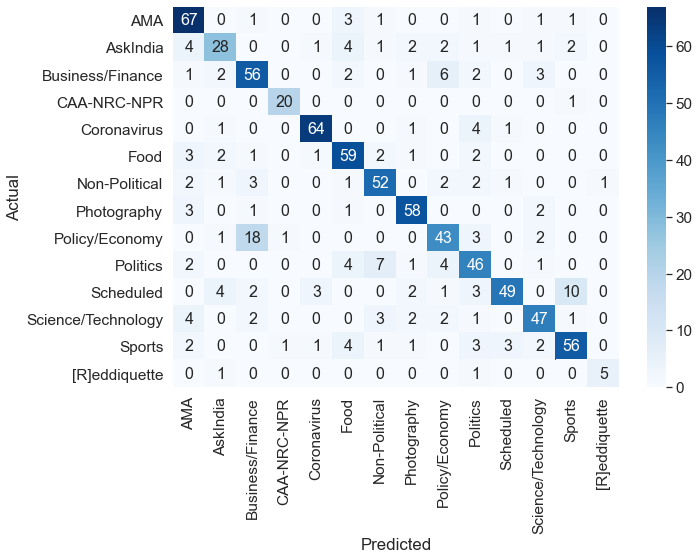

In [33]:
clf=RandomForestClassifier(n_estimators = 1000, random_state = 42)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

In [86]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [77]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
#dummy_y = np_utils.to_categorical(encoded_Y)

In [87]:
y_cat=np_utils.to_categorical(encoded_Y)

In [89]:
y_cat.shape

(2791, 14)

In [92]:
encoder.fit(y_train)
encoded_ytrain = encoder.transform(y_train)
encoder.fit(y_test)
encoded_ytest = encoder.transform(y_test)

### Using ANN

In [96]:
voc_size=40000
onehot=[one_hot(words,voc_size) for words in preprocessed_reviews]

In [118]:
sent_length=20000
embedded_docs=pad_sequences(onehot,padding='pre',maxlen=sent_length)

In [119]:
dim=15000

In [123]:
model=Sequential()
model.add(Embedding(voc_size,12000,input_length=sent_length))
model.compile('adam','mse')

In [ ]:
print(model.predict(embedded_docs)[0])

In [97]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout, LeakyReLU, ReLU,PReLU,ELU
import tensorflow as tf
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [52]:
classifier= Sequential()

In [56]:
len(df.flair.value_counts())

14

In [120]:
classifier.add(Embedding(voc_size,12000,input_length=sent_length))
classifier.add(Dense(256,kernel_initializer='he_uniform',activation='relu'))
classifier.add(Dense(256, activation='relu',kernel_initializer='he_uniform'))
classifier.add(Dropout(0.1))
classifier.add(Dense(128,activation='relu'))
#classifier.add(Dropout(0.1))
classifier.add(Dense(64, activation='relu'))
classifier.add(Dropout(0.1))
classifier.add(Dense(14, activation='softmax',kernel_initializer='glorot_uniform'))

In [121]:
classifier.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [122]:
model_history=classifier.fit(X_train_bow,encoded_ytrain,validation_split=0.2,batch_size=10,epochs=150)

ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'scipy.sparse.csr.csr_matrix'>]

In [60]:
y_train

1058    Science/Technology
1097              Politics
1741        Policy/Economy
344          Non-Political
839            Photography
               ...        
1638        Policy/Economy
1095              Politics
1130              Politics
1294              Politics
860            Photography
Name: flair, Length: 1953, dtype: object